# SIFT clustering

In [1]:
import os
import cv2
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%config InlineBackend.figure_format = "svg"
plt.rcParams["figure.figsize"] = 10, 6
plt.rcParams["image.cmap"] = "gray"

In [2]:
path_clean = "dataset/istock/clean"
path_marked = "dataset/istock/watermarked"

In [3]:
def load_imgs(dir_path):
    imgs = []
    for img_path in sorted(os.listdir(dir_path)):
        img = cv2.cvtColor(cv2.imread(dir_path + "/" + img_path), cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (img.shape[1] * 400 // img.shape[0], 400))
        imgs.append(img)
    return imgs

clean_imgs = load_imgs(path_clean)
marked_imgs = load_imgs(path_marked)

In [4]:
def img_keypoints_to_coords(img_keypoints):
    return np.array([k.pt for k in img_keypoints])

def make_keypoints_descriptors_coords(imgs):
    sift = cv2.SIFT_create()

    keypoints = []
    descriptors = []

    for img in imgs:
        kp, des = sift.detectAndCompute(img, None)
        keypoints.append(kp)
        descriptors.append(des)
        
    coords = []

    for img_keypoints in keypoints:
        coords.append(img_keypoints_to_coords(img_keypoints))

    all_coords = np.concatenate(coords)

    return keypoints, descriptors, all_coords

In [5]:
keypoints, descriptors, all_coords = make_keypoints_descriptors_coords(marked_imgs[:16])

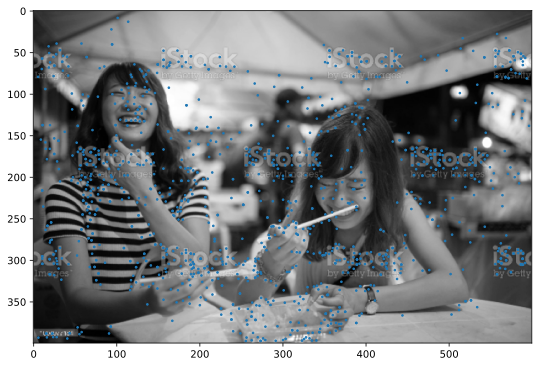

In [6]:
plt.imshow(marked_imgs[0])
x, y = zip(*[k.pt for k in keypoints[0]])
plt.scatter(x, y, s=3)
plt.show()

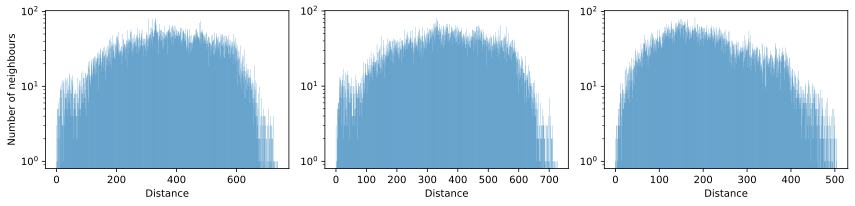

In [7]:
plt.figure(figsize=(12, 3))
for i, random_index in enumerate((5, 50, 500)):
    x = all_coords[random_index]
    
    dists = np.linalg.norm(all_coords - x, axis=1, ord=2)
    plt.subplot(1,3,i+1)
    plt.hist(dists, bins=1000)
    if i == 0:
        plt.ylabel("Number of neighbours")
    plt.xlabel("Distance")
    plt.yscale("log")
plt.tight_layout()
plt.show()

In [8]:
from sklearn.cluster import DBSCAN

def cluster_coords(all_coords, eps=3, min_samples=16):
    # eps selected by looking at histograms above and examining the number of clusters (I try to get ~10-40)
    # min_samples is selected to ensure that keypoint is present on several images

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    clustering = dbscan.fit(all_coords)
    
    return clustering.labels_


def split_labels_by_imgs(labels, keypoints):
    cutoffs = np.cumsum([0] + [len(k) for k in keypoints])

    chunked_labels = []

    for i in range(1, len(cutoffs)):
        chunked_labels.append(labels[cutoffs[i - 1]:cutoffs[i]])
    
    return chunked_labels

In [9]:
%%time
labels = cluster_coords(all_coords)
labels = split_labels_by_imgs(labels, keypoints)

CPU times: user 210 ms, sys: 19.9 ms, total: 230 ms
Wall time: 41.3 ms


In [10]:
n_unique_labels = len(np.unique(np.concatenate(labels)))
n_unique_labels

24

In [11]:
def plot_clusters(marked_imgs, keypoints, labels, nrows, ncols, n_unique_labels):
    plt.figure(figsize=(12, n_unique_labels * 8))
    nrows = nrows * n_unique_labels
    for label in range(-1, n_unique_labels - 1):
        for i, img in enumerate(marked_imgs):
            plt.subplot(nrows, ncols, (label + 1) * len(marked_imgs) + i + 1)

            x, y = zip(*[k.pt for k in keypoints[i]])

            mask = (labels[i] == label)
            
            x = np.array(x)[mask]
            y = np.array(y)[mask]
            
            plt.scatter(x, y)
            plt.title(f"Label {label}")
            plt.imshow(img)
            

    plt.tight_layout()
    plt.show()    

In [22]:
# Huge plot, uncomment with care

#plot_clusters(marked_imgs[:16], keypoints, labels, nrows=4, ncols=4, n_unique_labels=n_unique_labels)

In [13]:
def find_stable_keypoints(marked_imgs, keypoints, labels, n_unique_labels, stability_fraction=0.5):
    stable_keypoints = {}
    
    # drop -1 label (outliers)
    for label in range(n_unique_labels - 1):
        n_imgs_non_zero = 0
        
        stable_kp = []
        
        for i, img in enumerate(marked_imgs):

            x, y = zip(*[k.pt for k in keypoints[i]])

            mask = (labels[i] == label)
            
            n_imgs_non_zero += (mask.sum() >= 1)
            
            stable_kp.append(np.array(keypoints[i])[mask])
        
        if n_imgs_non_zero > len(marked_imgs) * stability_fraction:
            stable_keypoints[label] = stable_kp


    # each element of the list corresponds to one image 
    # each element of the list is a dictionary, 
    # which maps labels to an array of keypoints of a single image
    res = [{} for _ in range(len(marked_imgs))]

    for label, all_kps in stable_keypoints.items():
        for i, img_kps in enumerate(all_kps):
            res[i][label] = img_kps

    return res

In [14]:
stable_keypoints = find_stable_keypoints(marked_imgs[:16], keypoints, labels, n_unique_labels)

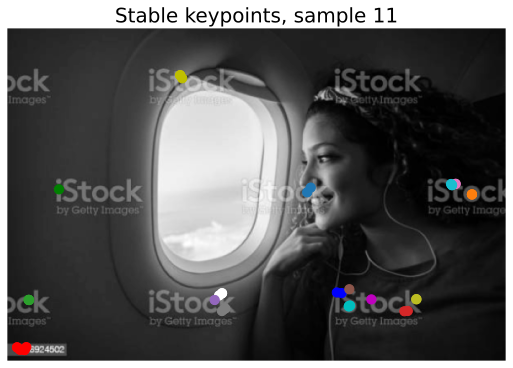

In [15]:
img_index = 11

colors = ["r", "g", "b", "c", "m", "y", "w"] + list(mcolors.TABLEAU_COLORS.values())

i = 0
for kps in stable_keypoints[img_index].values():
    if len(kps) > 0:
        coords = img_keypoints_to_coords(kps)
        x, y = coords.T
        plt.scatter(x, y, color=colors[i], s=85)
        i += 1

plt.title(f"Stable keypoints, sample {img_index}", fontsize=20)
plt.axis("off")
plt.imshow(marked_imgs[img_index])
plt.show()

We catched some watermarks. We can add descriptors, which are near the stable ones.

In [16]:
def expand_keypoints(stable_keypoints, keypoints, threshold):
    expanded_keypoints = []
    
    for stable_kp_dict, kp in zip(stable_keypoints, keypoints):
        img_keypoints = {}
        
        for label, stable_kp in stable_kp_dict.items():
            if len(stable_kp) == 0:
                continue

            # n_keypoints x 2
            coord = img_keypoints_to_coords(kp)
            # n_stable_keypoints x 2
            stable_coord = img_keypoints_to_coords(stable_kp)
            
            # n_keypoints x n_stable_keypoints
            dists = np.sqrt(np.sum(coord**2, axis=1)[..., None] - 2 * coord @ stable_coord.T + np.sum(stable_coord**2, axis=1)[None])
            mask = dists < threshold

            mask = mask.sum(1) > 0
            img_keypoints[label] = np.array(kp)[mask]


        expanded_keypoints.append(img_keypoints)
    
    return expanded_keypoints

In [17]:
expanded_keypoints = expand_keypoints(stable_keypoints, keypoints, 10)

In [18]:
len(expanded_keypoints), sum(len(v) for v in expanded_keypoints[0].values())

(16, 25)

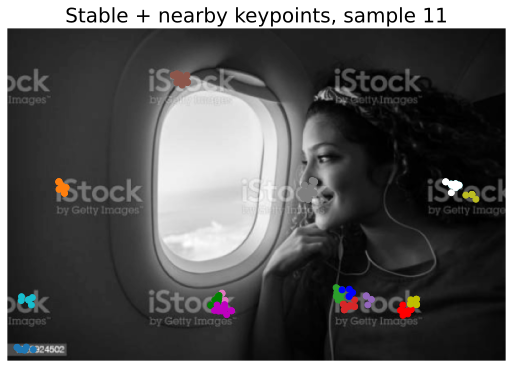

In [21]:
img_index = 11

colors = list(mcolors.TABLEAU_COLORS.values()) + ["r", "g", "b", "c", "m", "y", "w", "k"]

i = 0
for kps in expanded_keypoints[img_index].values():
    if len(kps) > 0:
        coords = img_keypoints_to_coords(kps)
        x, y = coords.T
        plt.scatter(x, y, color=colors[i])
        i += 1

plt.imshow(marked_imgs[img_index])
plt.title(f"Stable + nearby keypoints, sample {img_index}", fontsize=20)
plt.axis("off")
plt.show()